In [5]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn.functional as F
from collections import defaultdict
import numpy as np
import tqdm
import matplotlib.pyplot as plt


In [2]:
DATA_DIR = "C:\\Users\\nisad\\Desktop\\YapayZeka Uygulama\\archive\\images"
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [4]:
class FoodDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.samples = []
        for cls in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, cls)
            if not os.path.isdir(class_dir): continue
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.samples.append((img_path, cls))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        img_tensor = self.transform(img)
        return img_tensor, label, path


In [5]:
resnet = models.resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()
resnet = resnet.to(DEVICE)
resnet.eval()


c:\Users\nisad\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nisad\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
def extract_all_features(dataset, model, batch_size=32):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    vectors, labels, paths = [], [], []
    with torch.no_grad():
        for imgs, lbls, pths in tqdm.tqdm(dataloader):
            imgs = imgs.to(DEVICE)
            feats = model(imgs).cpu()
            vectors.append(feats)
            labels.extend(lbls)
            paths.extend(pths)
    return torch.cat(vectors), labels, paths



In [ ]:
from torchvision import models
import torch.nn as nn

resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Identity()  
resnet = resnet.to(DEVICE)
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
dataset = FoodDataset(DATA_DIR, transform)
features_path = "features.pt"

if os.path.exists(features_path):
    all_vectors = torch.load(features_path)
    with open("meta.txt", "r") as f:
        meta_lines = f.readlines()
    labels = [line.split("|||")[0] for line in meta_lines]
    paths = [line.strip().split("|||")[1] for line in meta_lines]
else:
    all_vectors, labels, paths = extract_all_features(dataset, resnet, batch_size=BATCH_SIZE)
    torch.save(all_vectors, features_path)
    with open("meta.txt", "w") as f:
        for lbl, p in zip(labels, paths):
            f.write(f"{lbl}|||{p}\n")


100%|██████████| 3157/3157 [1:59:58<00:00,  2.28s/it]


In [13]:
def find_most_similar(query_label):
    for i, lbl in enumerate(labels):
        if lbl == query_label:
            query_vec = all_vectors[i]
            break
    else:
        print("Sınıf bulunamadı."); return
    sims = F.cosine_similarity(query_vec.unsqueeze(0), all_vectors)
    sims[i] = -1
    top_idx = torch.topk(sims, k=1).indices[0].item()
    print(f"Sorgu: {query_label} → En benzer: {labels[top_idx]}")
    query_img = Image.open(paths[i])
    best_img = Image.open(paths[top_idx])
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(query_img); plt.title("Sorgu Resmi"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(best_img); plt.title(f"En Benzer: {labels[top_idx]}"); plt.axis("off")
    plt.tight_layout(); plt.show()


In [6]:
def evaluate_all_metrics(vectors, labels, top_k=5, num_samples_per_class=2):
    class_to_indices = defaultdict(list)
    for i, lbl in enumerate(labels):
        class_to_indices[lbl].append(i)
    total = correct_top1 = correct_topk = 0
    precision_sum = map_sum = ndcg_sum = 0
    for cls, idx_list in tqdm.tqdm(class_to_indices.items()):
        sampled = idx_list[:num_samples_per_class]
        for query_idx in sampled:
            query_vec = vectors[query_idx]
            sims = F.cosine_similarity(query_vec.unsqueeze(0), vectors)
            sims[query_idx] = -1
            topk_indices = torch.topk(sims, k=top_k).indices.tolist()
            retrieved_labels = [labels[i] for i in topk_indices]
            relevant = [1 if lbl == cls else 0 for lbl in retrieved_labels]
            if retrieved_labels[0] == cls: correct_top1 += 1
            if any(relevant): correct_topk += 1
            precision_sum += sum(relevant) / top_k
            num_rel = 0; ap = 0
            for i, rel in enumerate(relevant):
                if rel:
                    num_rel += 1
                    ap += num_rel / (i + 1)
            map_k = ap / max(1, sum(relevant))
            map_sum += map_k
            def dcg(rels): return sum([rel / np.log2(i+2) for i, rel in enumerate(rels)])
            ideal = sorted(relevant, reverse=True)
            ndcg = dcg(relevant) / (dcg(ideal) + 1e-8)
            ndcg_sum += ndcg
            total += 1
    print(f"Top-1 Accuracy:     {correct_top1 / total:.4f}")
    print(f"Top-{top_k} Accuracy:  {correct_topk / total:.4f}")
    print(f"Recall@{top_k}:     {correct_topk / total:.4f}")
    print(f"Precision@{top_k}:  {precision_sum / total:.4f}")
    print(f"MAP@{top_k}:         {map_sum / total:.4f}")
    print(f"NDCG@{top_k}:        {ndcg_sum / total:.4f}")

import torch
from collections import defaultdict

vectors = torch.load("features.pt")

# Etiketleri oku
with open("meta.txt", "r") as f:
    meta_lines = f.readlines()

labels = [line.split("|||")[0] for line in meta_lines]

# Fonksiyonu çağır
evaluate_all_metrics(vectors, labels, top_k=5, num_samples_per_class=2)


100%|██████████| 101/101 [02:41<00:00,  1.60s/it]

Top-1 Accuracy:     0.4455
Top-5 Accuracy:  0.6881
Recall@5:     0.6881
Precision@5:  0.3950
MAP@5:         0.5166
NDCG@5:        0.5690


Sorgu: beet_salad → En benzer: foie_gras


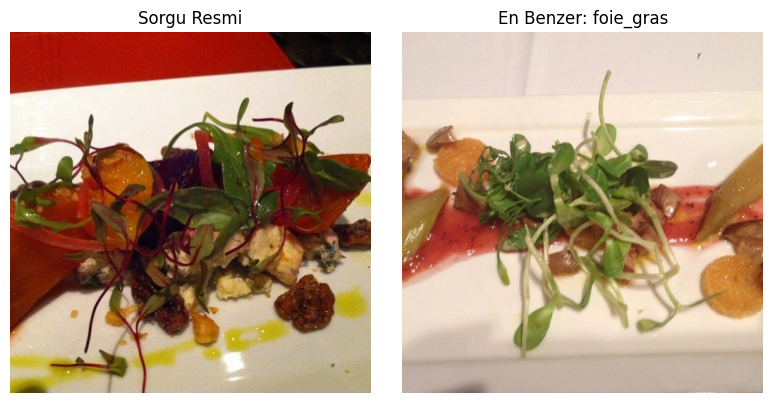

Sorgu: bibimbap → En benzer: croque_madame


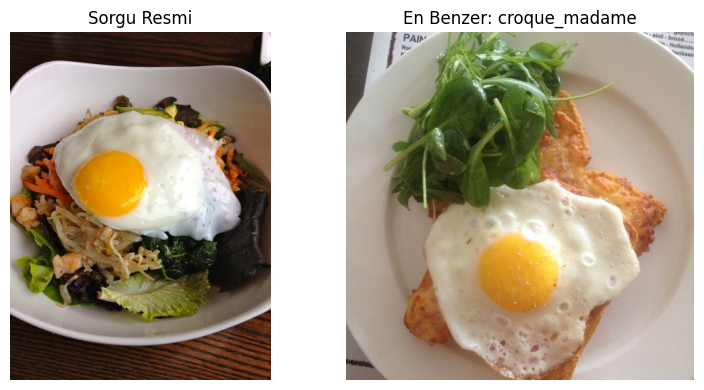

Sorgu: falafel → En benzer: pork_chop


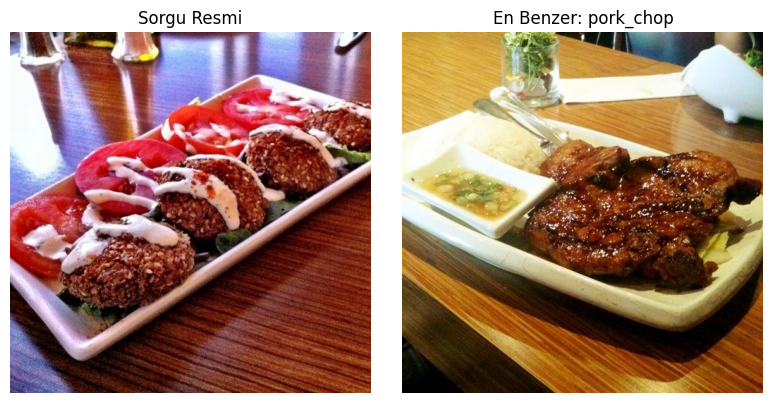

Sorgu: spaghetti_bolognese → En benzer: garlic_bread


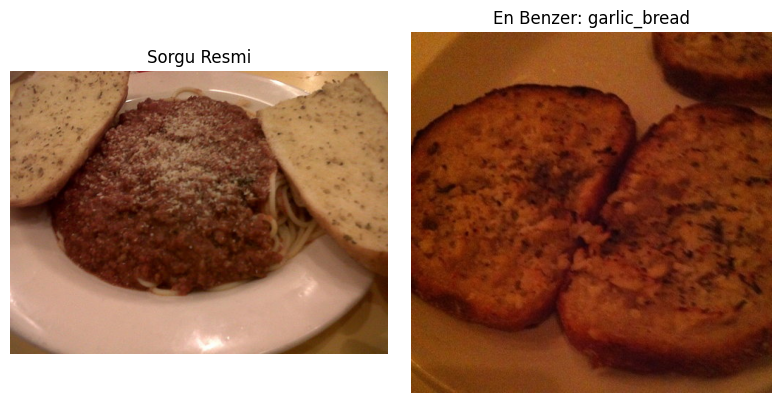

In [ ]:
find_most_similar("beet_salad")         
find_most_similar("bibimbap")         
find_most_similar("falafel")       
find_most_similar("spaghetti_bolognese")  